In [14]:
# import the necessary datasets
import pandas as pd # for data handling
import numpy as np # for mathematical operations
from datetime import datetime,timedelta # for working with dates
%matplotlib inline
import matplotlib.pyplot as plt # for plotting
#style.use('seaborn-whitegrid')
import matplotlib
import pickle
import csv
#import xarray as xr

# NICE colorscheme for scientific purposes, I can recommend: https://pypi.org/project/cmcrameri/
#from cmcrameri import cm
#from cmcrameri.cm import show_cmaps 

pd.set_option('display.max_columns', 40)


some simple functions to make your life easier

In [16]:
'''import Picarro file for files in normal Air mode (no 17O measurements)'''
def loadPICfile_LAB(filePIC):
    dfPIC=pd.read_csv(filePIC,index_col=(0),parse_dates=[2],skipinitialspace=True,na_values=['NAN'],dtype={'FRAC_DAYS_SINCE_JAN1': np.float64,'Picarro':str,'Port':str,'Analysis':str,'Port':str,'Sample':str})
    dfPIC.rename(inplace=True,columns={ 
            'd(D_H)Mean': 'dD',
            'ValveMask': 'Valve',
            'd(18_16)Mean':'d18',
            'd(17_16)Mean':'d17',
            'H2O_Mean':'H2O',
            'FRAC_DAYS_SINCE_JAN1':'DOY',
            'Inj Nr':'Inj',
            'Time Code':'time',
            'd(17_16)_SD':'d17sd',
            'd(18_16)_SD':'d18sd',
            'd(D_H)_SD':'dDsd'})
    # add deuterium excess to the dataframe
    dfPIC['dex']=pd.Series(data=(dfPIC.dD-8*dfPIC.d18),index=dfPIC.index)
    
    return dfPIC

''' so I dont always have to type figsize and subplots'''
def plot1(figsize=(12,6)):
    fig,ax=plt.subplots(1,1,figsize=figsize)
    axi=ax.twinx()
    ax.tick_params(axis='both', which='major', labelsize=18)
    axi.tick_params(axis='both', which='major', labelsize=18)
    return fig,ax,axi


def plot2(figsize=(12,6),shax=True,timeseries=True):
    if timeseries==True:
        fig,(ax1,ax2)=plt.subplots(2,1,figsize=figsize,sharex=shax)
    if timeseries==False:
        fig,(ax1,ax2)=plt.subplots(1,2,figsize=figsize,sharey=shax)        
        
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    return fig,ax1,ax2



In [9]:
# If you want to reset all variables without reloading all modules
%reset -f
var

NameError: name 'var' is not defined

# Task:
__Perform a calibration of the IAEA test samples by averaging the last 5 injections of each sample__

__read in the information about the secondary IN-HOUSE standards from the SNOWISO lab__

In [18]:
# standards
filstd='UiB_standards_Mar2025.csv'
dfstd=pd.read_csv(filstd,index_col=0)

#dfstd.to_pickle('Standards_pickle.pkl')
print(dfstd)

                     d17        d18          dD
Name                                           
BERMUDA         0.488166   0.924932    8.382397
M10            -5.152775  -9.766813  -66.599696
M20           -10.383131 -19.552503 -144.524283
M30           -15.713870 -29.530051 -224.152118
M43           -22.743271 -42.691800 -329.140380
M54           -28.855076 -53.940519 -422.917598
UIB-GREENLAND   0.000000 -41.830000 -322.290000
LSCE-VSAEL      0.000000 -61.050000 -475.040000
UNIVE-DC        0.000000 -52.400000 -407.130000
AWI-LDC         0.000000 -49.150000 -383.670000


calibrate the IAEA test samples

In [39]:
filePIC1='HKDS2156_IsoWater_20240820_072303.csv'
dfPIC1=loadPICfile_LAB(filePIC1)
dfPIC1meas=pd.DataFrame(columns=['d18','dD','d17','d18sd','dDsd','d17sd'])

filePIC2='HKDS2156_IsoWater_20240827_083808.csv'
dfPIC2=loadPICfile_LAB(filePIC2)

samples=list(dfPIC1['Identifier 1'].drop_duplicates())
print('The samples identified in the Picarro file:',samples)


The samples identified in the Picarro file: ['BERMUDA', 'OH_32', 'OH_34', 'M10', 'OH_35', 'OH_31', 'M20', 'OH_33', 'M54']


__Step1: average the last 5 injections and use as "measured value"__

In [114]:
#for sample in samples:
df5avg=dfPIC1.groupby(dfPIC1['Identifier 1']).apply(lambda g: g.loc[:,['d18','dD','d17','dex','d18sd','dDsd','d17sd']].tail(5).mean(),include_groups=False)
      #.reset_index(name='Mean_of_Last_5')

df5avg

,d18,dD,d17,dex,d18sd,dDsd,d17sd
Identifier 1,,,,,,,
BERMUDA,-12.4722,32.11940,-9.81260,131.89700,0.18340,0.3316,0.2234
M10,-23.0828,-48.79920,-15.47100,135.86320,0.16120,0.3138,0.2118
M20,-32.7718,-132.84260,-20.70180,129.33180,0.17260,0.3158,0.2270
M54,-66.9605,-433.33375,-39.22275,102.35025,0.16375,0.3515,0.2145
OH_31,-29.2570,-99.44340,-18.76860,134.61260,0.17200,0.3316,0.2150
OH_32,-12.1468,41.63200,-9.68180,138.80640,0.17260,0.3282,0.2260
OH_33,-35.4704,-152.51240,-22.11100,131.25080,0.16960,0.3072,0.2204
OH_34,-18.3518,-24.16860,-12.96840,122.64580,0.17200,0.3182,0.2194
OH_35,-23.9368,-58.16360,-15.91900,133.33080,0.17280,0.3162,0.2194


In [134]:
pd

NameError: name 'pd' is not defined

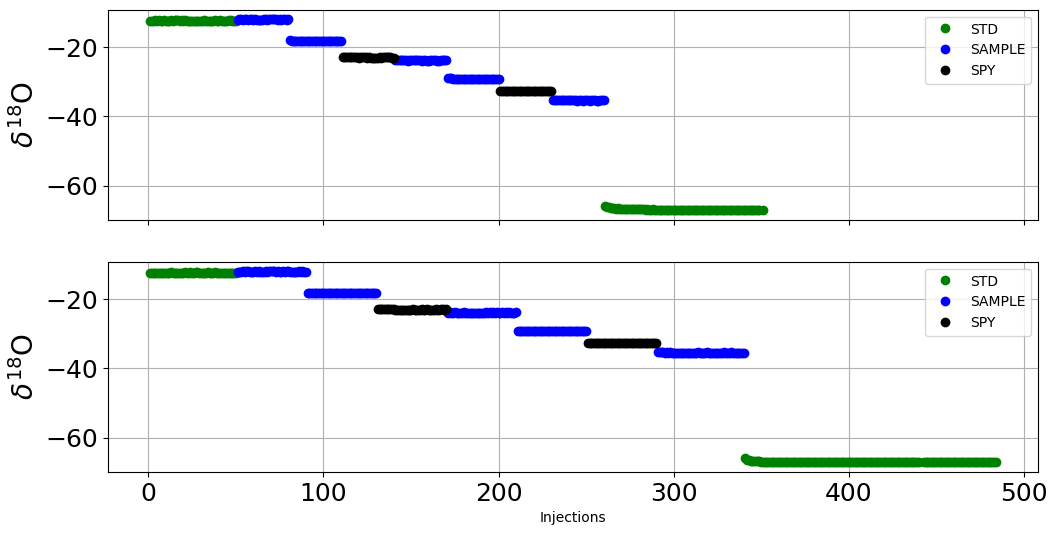

In [61]:
fig,ax1,ax2=plot2()

ax1.plot(dfPIC1[dfPIC1['Identifier 2']=='STD'].index,dfPIC1[dfPIC1['Identifier 2']=='STD'].d18,marker='o',ls='',color='green',label='STD')
ax1.plot(dfPIC1[dfPIC1['Identifier 2']=='SAMPLE'].index,dfPIC1[dfPIC1['Identifier 2']=='SAMPLE'].d18,marker='o',ls='',color='blue',label='SAMPLE')
ax1.plot(dfPIC1[dfPIC1['Identifier 2']=='SPY'].index,dfPIC1[dfPIC1['Identifier 2']=='SPY'].d18,marker='o',ls='',color='k',label='SPY')
ax1.legend()
ax1.grid()
ax1.set_ylabel(r'$\delta^{18}$O',fontsize=20)

ax2.plot(dfPIC2[dfPIC2['Identifier 2']=='STD'].index,dfPIC2[dfPIC2['Identifier 2']=='STD'].d18,marker='o',ls='',color='green',label='STD')
ax2.plot(dfPIC2[dfPIC2['Identifier 2']=='SAMPLE'].index,dfPIC2[dfPIC2['Identifier 2']=='SAMPLE'].d18,marker='o',ls='',color='blue',label='SAMPLE')
ax2.plot(dfPIC2[dfPIC2['Identifier 2']=='SPY'].index,dfPIC2[dfPIC2['Identifier 2']=='SPY'].d18,marker='o',ls='',color='k',label='SPY')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Injections')
ax2.set_ylabel(r'$\delta^{18}$O',fontsize=20)

fig

General formula for calibration

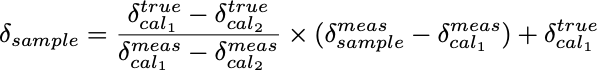

establish calibration function

In [38]:
def calibrate(dsample,iso='d18'):
    ''' select d18, d17 or dD as isotope species'''
    m=(dfstd.loc['BERMUDA',iso]-dfstd.loc['M54',iso])/(df5avg.loc['BERMUDA',iso]-df5avg.loc['M54',iso])
    c=dfstd.loc['BERMUDA',iso]
    x=(dsample-df5avg.loc['BERMUDA',iso])
    return m*x+c
    
    

In [57]:
dfSPYcali_d18=calibrate(df5avg.loc[['M10','M20'],'d18'],iso='d18').round(3)
dfSPYcali_d17=calibrate(df5avg.loc[['M10','M20'],'d17'],iso='d17').round(3)
dfSPYcali_dD=calibratedf5avg.loc[['M10','M20'],'dD'],iso='dD').round(3)

dfcali_d18=calibrate(df5avg[df5avg.index.str.contains('OH')].loc[:,'d18'],iso='d18').round(3)
dfcali_d17=calibrate(df5avg[df5avg.index.str.contains('OH')].loc[:,'d17'],iso='d17').round(3)
dfcali_dD=calibrate(df5avg[df5avg.index.str.contains('OH')].loc[:,'dD'],iso='dD').round(3)

In [63]:
# error based on SPY

print('Error d18O: \n',dfSPYcali_d18-dfstd.loc[['M10','M20'],'d18'],'\n-----------------------------------------')
print('Error d17O: \n',dfSPYcali_d17-dfstd.loc[['M10','M20'],'d17'],'\n-----------------------------------------')
print('Error dD: \n',dfSPYcali_dD-dfstd.loc[['M10','M20'],'dD'],'\n-----------------------------------------')


Error d18O: 
 Identifier 1
M10    0.007813
M20    0.037503
Name: d18, dtype: float64 
-----------------------------------------
Error d17O: 
 Identifier 1
M10   -0.004225
M20    0.007131
Name: d17, dtype: float64 
-----------------------------------------
Error dD: 
 Identifier 1
M10    0.000696
M20    0.049283
Name: dD, dtype: float64 
-----------------------------------------


result:


In [65]:
print('Result d18O:')
dfcali_d18

Result d18O:


Identifier 1
OH_31   -15.976
OH_32     1.253
OH_33   -22.232
OH_34    -4.995
OH_35   -10.619
Name: d18, dtype: float64

In [66]:
print('Result d17O:')
dfcali_d17

Result d17O:


Identifier 1
OH_31    -8.447
OH_32     0.619
OH_33   -11.782
OH_34    -2.660
OH_35    -5.604
Name: d17, dtype: float64

In [67]:
print('Result dD:')
dfcali_dD

Result dD:


Identifier 1
OH_31   -113.527
OH_32     17.197
OH_33   -162.702
OH_34    -43.775
OH_35    -75.276
Name: dD, dtype: float64

Solution:

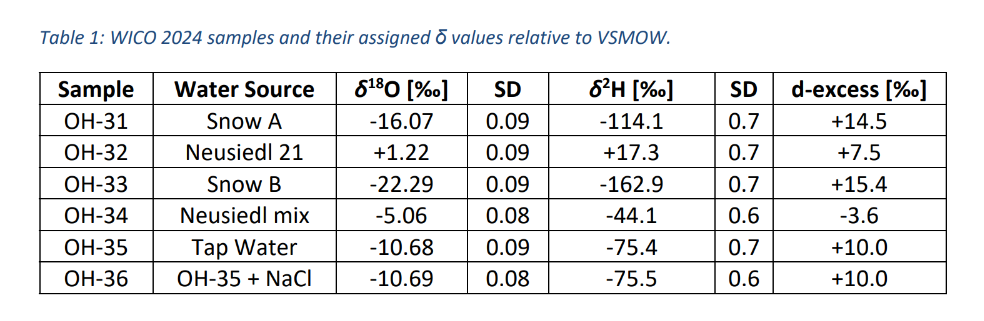

# Error propagation d-excess

In [112]:
err_d18O = 0.1 # in permille
err_d2H = 1 # in permille

# Linear definition of the d-excess: dxs = dH - 8*d18O
tot_err_dxs = np.sqrt(err_d2H**2 + (8*err_d18O)**2) # total error d-excess
print('Total error d-excess:', tot_err_dxs)

Total error d-excess: 1.2806248474865698
